In [1]:
import json
import torch
import random
from PIL import Image
from tqdm import tqdm
import pickle

## Set Up

In [12]:
train = json.load(open("../imSitu/train.json"))
val = json.load(open("../imSitu/dev.json"))
test = json.load(open("../imSitu/test.json"))
imsitu_space = json.load(open("../imSitu/imsitu_space.json"))
nouns = imsitu_space["nouns"]
verbs = imsitu_space["verbs"]

In [27]:
def sample_from_dict(d, sample=10):
    keys = random.sample(list(d), sample)
    values = [d[k] for k in keys]
    return dict(zip(keys, values))

In [ ]:
random.seed(10)
val_sample = sample_from_dict(val, sample=10)
val_sample

In [13]:
def get_noun_labels(data):
    updated_data = {}

    # Replace 'nxxxxxx' strings in dev set with the first word in their gloss
    for image, data in data.items():
        updated_data[image] = {'frames': [], 'verb': data['verb']}
        for frame in data['frames']:
            new_frame = {}
            for role, noun in frame.items():
                new_frame[role] = nouns[noun]['gloss'][0] if noun in nouns else noun
            updated_data[image]['frames'].append(new_frame)

    return updated_data

In [14]:
updated_dev_set = get_noun_labels(val)

In [20]:
example_images = '../data/of500_images_resized/prowling_234.jpg,../data/of500_images_resized/spraying_141.jpg,../data/of500_images_resized/slipping_166.jpg'.split(',')

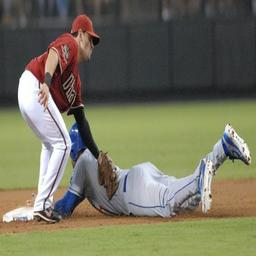

In [23]:
from PIL import Image
Image.open(example_images[2])

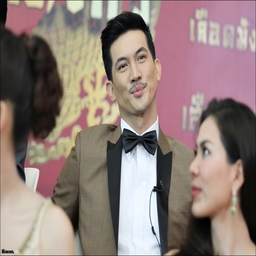

In [19]:
from PIL import Image
Image.open("../data/of500_images_resized/puckering_158.jpg") #puckering_158.jpg

In [20]:
output['puckering_158.jpg']

{'Verb': 'Puckering',
 'Roles_and_Nouns': {'agentpart': [''], 'place': [''], 'agent': ['']}}

In [22]:
output['puckering_158.jpg']['Roles_and_Nouns'].keys()

dict_keys(['agentpart', 'place', 'agent'])

In [21]:
updated_dev_set['puckering_158.jpg']

{'frames': [{'agentpart': 'lip', 'place': 'red carpet', 'agent': 'man'},
  {'agentpart': 'lip', 'place': 'room', 'agent': 'man'},
  {'agentpart': 'mouth', 'place': 'ceremony', 'agent': 'man'}],
 'verb': 'puckering'}

## Run VILA initial

In [15]:
json_visual_prompt = """Given the image, provide a structured situational summary following the JSON response format template, that captures the essence of the scene. Specifically, if an action or activity is taking place, describe the action (verb). Then give up to 6 framenet roles associated with this verb (action). Finally give the labels (nouns) filling these roles.
JSON Response Format Template: {{
  "Verb": "Prowling",
  "Roles_and_Nouns": {{
    "Role1": {},
    "Role2": {},
    "Role3": {}
  }}
}}

In-Context Examples for Guidance: {{
<image>
  "Verb": "Prowling",
  "Roles_and_Nouns": {{
    "Place": "Outdoors",
    "Target": "Prey",
    "Agent": "Wolf"
  }}

<image>
  "Verb": "Spraying",
  "Roles_and_Nouns": {{
    "Destination": "Tree",
    "Substance": "Water",
    "Place": "Forest",
    "Agent": "Person",
    "Source": "Hose",
  }}
  
<image>
  "Verb": "Slipping",
  "Roles_and_Nouns": {{
    "destination": "base",
    "place": "playing field",
    "Substance": "Water",
    "agent": "player",
  }}
}}
Do not give an explanation or any more unnessary information other than the JSON format.
Now, based on the image <image>, provide a structured summary in the JSON format as instructed above.
"""

In [1]:
import subprocess

json_visual_prompt = """Given the image, provide a structured situational summary following the JSON response format template, that captures the essence of the scene. Specifically, if an action or activity is taking place, describe the action (verb). Then give up to 6 framenet roles associated with this verb (action). Finally give the labels (nouns) filling these roles.
JSON Response Format Template: {{
  "Verb": {},
  "Roles_and_Nouns": {{
    "Role1": {},
    "Role2": {},
    "Role3": {}
  }}
}}

In-Context Examples for Guidance: {{
<image>
  "Verb": "Prowling",
  "Roles_and_Nouns": {{
    "Place": "Outdoors",
    "Target": "Prey",
    "Agent": "Wolf"
  }}

<image>
  "Verb": "Spraying",
  "Roles_and_Nouns": {{
    "Destination": "Tree",
    "Substance": "Water",
    "Place": "Forest",
    "Agent": "Person",
    "Source": "Hose"
  }}
  
<image>
  "Verb": "Slipping",
  "Roles_and_Nouns": {{
    "destination": "base",
    "place": "playing field",
    "agent": "player"
  }}
}}
Do not give an explanation or any more unnessary information other than the JSON format.
Now, based on the image <image>, provide a structured summary in the JSON format as instructed above.
"""

image_files = "../data/of500_images_resized/prowling_234.jpg,../data/of500_images_resized/spraying_141.jpg,../data/of500_images_resized/slipping_166.jpg,../data/of500_images_resized/hitchhiking_238.jpg"

# Prepare the command
command = [
    "python", "-W", "ignore", "./llava/eval/run_vila.py",
    "--model-path", "Efficient-Large-Model/Llama-3-VILA1.5-8b",
    "--conv-mode", "llama_3",
    "--query", json_visual_prompt,
    "--image-file", image_files
]

# Run the command using subprocess
result = subprocess.run(command, capture_output=True, text=True)

# Print the output and error
print("Output:", result.stdout)
#print("Error:", result.stderr)

Output: {
"Verb": "Standing",
"Roles_and_Nouns": {
"Place": "Roadside",
"Person": "Man",
"Object": "Backpack",
"Source": "Hitchhiking"
}
}



## Run VILA Final

In [12]:
json_prompt_top5 = """
Given the image, provide a structured situational summary following the JSON response format template, that captures the essence of the scene. Specifically, if an action or activity is taking place, describe the action (verb). Then give up to 6 framenet roles associated with this verb (action). For each role, provide the top 5 labels (nouns) filling these roles, ranked from most likely to least likely.
JSON Response Format Template: {{
  "Verb": "{verb}",
  "Roles_and_Nouns": {{
    {roles_json}
  }}
}}

In-Context Examples for Guidance: {{
<image>
{{
  "Verb": "Prowling",
  "Roles_and_Nouns": {{
    "Place": "Outdoors",
    "Target": "Prey",
    "Agent": "Wolf"
  }}
}}
<image>
{{
  "Verb": "Spraying",
  "Roles_and_Nouns": {{
    "Destination": "Tree",
    "Substance": "Water",
    "Place": "Forest",
    "Agent": "Person",
    "Source": "Hose"
  }}
}}
<image>
{{
  "Verb": "Slipping",
  "Roles_and_Nouns": {{
    "Destination": "Base",
    "Place": "Playing Field",
    "Agent": "Player"
  }}
}}
}}
Now, based on the image <image>, verb {verb} and roles {roles_list}, fill in the structured summary below and include the top 5 labels (nouns) filling these roles.
"""


In [16]:
def generate_prompt(json_visual_prompt, verb, roles, top_n):
    if top_n == 1:
        roles_json = ",\n    ".join([f'"{role}": [""]' for role in roles])
    else:
        roles_json = ",\n    ".join([f'"{role}": ["", "", "", "", ""]' for role in roles])
    roles_list = ", ".join(roles)

    return json_visual_prompt.format(verb=verb, roles_json=roles_json, roles_list=roles_list)

In [22]:
import os
imgs = os.listdir("../data/of500_images_resized/")
len(imgs)

126104

In [17]:
verb = "prowling"
roles = ['destination', 'place', 'agent']
formatted_prompt = generate_prompt(json_visual_prompt, verb, roles, 1)
#formatted_prompt = json_prompt_top5.format(verb=verb, roles_json=roles_json, roles_list=roles_list)

In [18]:
formatted_prompt

'\nGiven the image, provide a structured situational summary following the JSON response format template, that captures the essence of the scene. If an action or activity is taking place, describe the action (verb). Then, for each role associated with this verb (action), provide the top 5 labels (nouns) filling these roles, ranked from most likely to least likely.\nJSON Response Format Template:\n{\n  "Verb": "prowling",\n  "Roles_and_Nouns": {\n    "destination": [""],\n    "place": [""],\n    "agent": [""]\n  }\n}\n\nIn-Context Examples for Guidance:\n<image>\n{\n  "Verb": "Prowling",\n  "Roles_and_Nouns": {\n    "Place": ["Outdoors"],\n    "Target": ["Prey"],\n    "Agent": ["Wolf"]\n  }\n}\n<image>\n{\n  "Verb": "Spraying",\n  "Roles_and_Nouns": {\n    "Destination": ["Tree"],\n    "Substance": ["Water"],\n    "Place": ["Forest"],\n    "Agent": ["Person"],\n    "Source": ["Hose"]\n  }\n}\n<image>\n{\n  "Verb": "Slipping",\n  "Roles_and_Nouns": {\n    "Destination": ["Base"],\n    "P

In [14]:
import subprocess

# Save the json_visual_prompt to a file
json_visual_prompt = """
Given the image, provide a structured situational summary following the JSON response format template, that captures the essence of the scene. If an action or activity is taking place, describe the action (verb). Then, for each role associated with this verb (action), provide the top 5 labels (nouns) filling these roles, ranked from most likely to least likely.
JSON Response Format Template:
{{
  "Verb": "{verb}",
  "Roles_and_Nouns": {{
    {roles_json}
  }}
}}

In-Context Examples for Guidance:
<image>
{{
  "Verb": "Prowling",
  "Roles_and_Nouns": {{
    "Place": ["Outdoors"],
    "Target": ["Prey"],
    "Agent": ["Wolf"]
  }}
}}
<image>
{{
  "Verb": "Spraying",
  "Roles_and_Nouns": {{
    "Destination": ["Tree"],
    "Substance": ["Water"],
    "Place": ["Forest"],
    "Agent": ["Person"],
    "Source": ["Hose"]
  }}
}}
<image>
{{
  "Verb": "Slipping",
  "Roles_and_Nouns": {{
    "Destination": ["Base"],
    "Place": ["Playing Field"],
    "Agent": ["Player"]
  }}
}}
Now, based on the image <image>, verb {verb} and roles {roles_list}, fill in the structured summary below and include the label (noun) that fills each role.
"""

# with open("json_visual_prompt.txt", "w") as f:
#     f.write(json_visual_prompt)


In [3]:
# Define the command to run the script
command = [
    "python", "-W", "ignore", "./llava/eval/imsitu_VILA_new.py",
    "--model-path", "Efficient-Large-Model/Llama-3-VILA1.5-8b",
    "--data_file", "../imSitu/dev.json",
    "--image_dir", "../data/of500_images_resized",
    "--sample_data", "-1",
    "--output_file", "./output_top1.json",
    "--json_visual_prompt", 'json_visual_prompt.txt',
    "--example_images", "../data/of500_images_resized/prowling_234.jpg,../data/of500_images_resized/spraying_141.jpg,../data/of500_images_resized/slipping_166.jpg",
    "--conv-mode", "llama_3"
]

# Run the command
result = subprocess.run(command, capture_output=True, text=True)

KeyboardInterrupt: 

In [20]:
result.stdout
result.stderr

'usage: imsitu_VILA_new.py [-h] [--model-path MODEL_PATH]\n                          [--model-base MODEL_BASE] --data_file DATA_FILE\n                          --image_dir IMAGE_DIR --output_file OUTPUT_FILE\n                          --json_visual_prompt_file JSON_VISUAL_PROMPT_FILE\n                          --example_images EXAMPLE_IMAGES\n                          [--conv-mode CONV_MODE] [--sep SEP]\n                          [--temperature TEMPERATURE] [--top_p TOP_P]\n                          [--num_beams NUM_BEAMS]\n                          [--max_new_tokens MAX_NEW_TOKENS] [--top_n TOP_N]\nimsitu_VILA_new.py: error: unrecognized arguments: --sample_data -1\n'

## Evaluate VILA-imsitu

In [4]:
import json
val = json.load(open("../imSitu/dev.json"))
test = json.load(open("../imSitu/test.json"))
imsitu_space = json.load(open("../imSitu/imsitu_space.json"))
nouns = imsitu_space["nouns"]
#output = json.load(open('./output_top1.json', 'r'))
output = json.load(open('./imsitu_output_top1_dev.json', 'r'))
output_test_empty = json.load(open('./imsitu_output_top1_test_empty.json', 'r'))
output_test = json.load(open('./imsitu_output_top1_test.json', 'r'))

In [2]:
val = json.load(open("../imSitu/dev.json"))

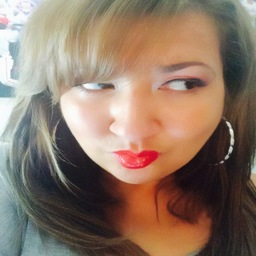

In [3]:
from PIL import Image
Image.open("../data/of500_images_resized/puckering_45.jpg") # ../data/of500_images_resized/puckering_45.jpg

In [5]:
def check_role_in_gloss(role, output, frames):
    for frame in frames:
        if (role not in frame) or (frame[role]==''):
            continue
        nounlist = nouns[frame[role]]['gloss']
        if output.lower() in nounlist:
            return True
    return False

def get_score(preds, dataset):
    # Counters
    value_counter = 0
    value_all_counter = 0
    empty_all_counter = 0
    total_images = len(dataset)
    
    # Processing each image in the dev set
    for image, frame_dict in dataset.items():
        if image not in preds:
            empty_all_counter += 1
            continue
        if preds[image] == None:
            empty_all_counter += 1
            continue
        else:
            #print(output[image])
            #print(image)
            try:
                role_nouns = preds[image]['Roles_and_Nouns']
            except:
                continue
        frames = frame_dict['frames']

        at_least_one_correct = False
        all_correct = True
        all_empty = True
        # output list is list of top 1 or top 5 predicted nouns per role
        for role, output_list in role_nouns.items():
            if output_list and output_list[0]:  # Check if the list is not empty and not a single empty string
                all_empty = False
                correct = any(check_role_in_gloss(role.lower(), output, frames) for output in output_list)
                if correct:
                    at_least_one_correct = True
                else:
                    all_correct = False
            elif not output_list or (output_list and output_list[0] == ''):
                all_correct = False

        if at_least_one_correct:
            value_counter += 1
        if all_correct and not all_empty:
            value_all_counter += 1
        if all_empty:
            empty_all_counter += 1

    # Calculate average scores
    average_value_score = value_counter / total_images
    average_value_all_score = value_all_counter / total_images
    average_empty_all_score = empty_all_counter / total_images
    print(f"Total Images: {total_images}")
    print(f"Value Counter: {value_counter}")
    print(f"Value-All Counter: {value_all_counter}")
    print(f"Empty-All Counter: {empty_all_counter}")
    print(f"Average Value Score: {average_value_score}")
    print(f"Average Value-All Score: {average_value_all_score}")
    print(f"Average Empty-All Score: {average_empty_all_score}")

In [ ]:
updated_dev_set = get_noun_labels(val)

In [16]:
output_empty = json.load(open('./imsitu_output_top1_empty.json', 'r'))
output_missing = json.load(open('./imsitu_output_top1_missing.json', 'r'))
#get_score(output_empty, val_empty)

In [8]:
def update_dict(original, new):
    for key, value in new.items():
        original[key] = new[key]
        #output_missing[key] = value
    return original


In [9]:
new_test = update_dict(output_test, output_test_empty)

In [17]:
add_missing = update_dict(output, output_missing)

In [18]:
add_empty_and_missing = update_dict(add_missing, output_empty)

In [33]:
add_empty_and_missing['blocking_45.jpg']

In [19]:
data = {}
for key in add_empty_and_missing.keys():
    if add_empty_and_missing[key] == None:
        data[key] = add_empty_and_missing.get(key, None)
    else:
        data[key] = add_empty_and_missing[key].get('Roles_and_Nouns',None)


In [29]:
output_dict

{'hitchhiking_238.jpg': {'Place': ['Roadside'],
  'Agent': ['Man'],
  'Source': ['Backpack']},
 'flapping_1.jpg': {'Bodypart': ['Wings'],
  'Place': ['Air'],
  'Agent': ['Bird']},
 'puckering_158.jpg': {'Agentpart': [''], 'Place': [''], 'Agent': ['']},
 'grieving_75.jpg': {'Place': ['Cemetery'],
  'Agent': ['People'],
  'Source': ['Casket']},
 'shopping_2.jpg': {'Goods': ['Toiletries'],
  'Place': ['Store'],
  'Agent': ['Couple']},
 'saluting_277.jpg': {'Place': ['Military Base'],
  'Target': [''],
  'Agent': ['Soldier']},
 'standing_66.jpg': {'Place': ['Auditorium'],
  'Audience': ['People'],
  'Agent': ['Man']},
 'swarming_87.jpg': {'Agenttype': ['Ants'], 'Place': ['Table']},
 'parachuting_137.jpg': {'Parachute': [''],
  'Destination': [''],
  'Place': [''],
  'Agent': ['']},
 'blossoming_94.jpg': {'Place': ['Desert Plant'], 'agent': ['Desert Plant']},
 'competing_207.jpg': {'Place': ['Ring'],
  'Competition': ['Boxing Match'],
  'Agent': ['Boxer']},
 'whirling_196.jpg': {'Place': ['

In [25]:
output_dict = data.copy()

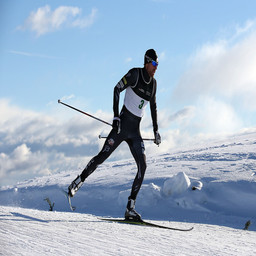

In [46]:
img_dir = '../data/of500_images_resized/'
from PIL import Image
import os
Image.open(os.path.join(img_dir, 'skiing_41.jpg'))

In [36]:
def format_roles_nouns(roles_nouns):
    return '\n'.join([f"{role}: {', '.join(nouns)}" for role, nouns in roles_nouns.items()])

# Function to format the frames into a string with line breaks
def format_frames(frames):
    return '\n\n'.join([', '.join([f"{role}: {noun}" for role, noun in frame.items()]) for frame in frames])

# Create a list of dictionaries to form the DataFrame
data = []

for image_name, image_info in updated_dev_set.items():
    output_info = output_dict.get(image_name, {})
    if not output_info:
        continue
    formatted_output = format_roles_nouns(output_info)
    formatted_frames = format_frames(image_info['frames'])
    data.append({'Image': image_name, 'Output Roles and Nouns': formatted_output, 'Dev Set Frames': formatted_frames})

# Create the DataFrame
df = pd.DataFrame(data)

In [39]:
df = df.set_index('Image')

In [40]:
d

,Output Roles and Nouns,Dev Set Frames
Image,,
hitchhiking_238.jpg,Place: Roadside\nAgent: Man\nSource: Backpack,"place: highway, agent: man\n\nplace: highway, ..."
flapping_1.jpg,Bodypart: Wings\nPlace: Air\nAgent: Bird,"bodypart: wing, place: outdoors, agent: bird\n..."
puckering_158.jpg,Agentpart: \nPlace: \nAgent:,"agentpart: lip, place: red carpet, agent: man\..."
grieving_75.jpg,Place: Cemetery\nAgent: People\nSource: Casket,"place: funeral, agent: family\n\nplace: funera..."
shopping_2.jpg,Goods: Toiletries\nPlace: Store\nAgent: Couple,"goods: food, place: grocery store, agent: coup..."
...,...,...
distracting_60.jpg,Place: Street\nVictim: Man on phone\nAgent: Ma...,"place: street, victim: man, agent: man\n\nplac..."
jogging_308.jpg,Place: Pathway\nAgent: Woman,"place: field, agent: woman\n\nplace: field, ag..."
tasting_37.jpg,Item: Wine\nTool: Glassware\nPlace: Restaurant...,"item: meal, tool: sauce, place: dining room, a..."


In [23]:
output

{'hitchhiking_238.jpg': {'Verb': 'Hitchhiking',
  'Roles_and_Nouns': {'Place': ['Roadside'],
   'Agent': ['Man'],
   'Source': ['Backpack']}},
 'flapping_1.jpg': {'Verb': 'Flapping',
  'Roles_and_Nouns': {'Bodypart': ['Wings'],
   'Place': ['Air'],
   'Agent': ['Bird']}},
 'puckering_158.jpg': {'Verb': 'Puckering',
  'Roles_and_Nouns': {'Agentpart': [''], 'Place': [''], 'Agent': ['']}},
 'grieving_75.jpg': {'Verb': 'Grieving',
  'Roles_and_Nouns': {'Place': ['Cemetery'],
   'Agent': ['People'],
   'Source': ['Casket']}},
 'shopping_2.jpg': {'Verb': 'shopping',
  'Roles_and_Nouns': {'Goods': ['Toiletries'],
   'Place': ['Store'],
   'Agent': ['Couple']}},
 'saluting_277.jpg': {'Verb': 'Saluting',
  'Roles_and_Nouns': {'Place': ['Military Base'],
   'Target': [''],
   'Agent': ['Soldier']}},
 'standing_66.jpg': {'Verb': 'Standing',
  'Roles_and_Nouns': {'Place': ['Auditorium'],
   'Audience': ['People'],
   'Agent': ['Man']}},
 'swarming_87.jpg': {'Verb': 'Swarming',
  'Roles_and_Nouns':

In [22]:
updated_dev_set

{'hitchhiking_238.jpg': {'frames': [{'place': 'highway', 'agent': 'man'},
   {'place': 'highway', 'agent': 'man'},
   {'place': 'road', 'agent': 'man'}],
  'verb': 'hitchhiking'},
 'flapping_1.jpg': {'frames': [{'bodypart': 'wing',
    'place': 'outdoors',
    'agent': 'bird'},
   {'bodypart': 'wing', 'place': 'lake', 'agent': 'bird'},
   {'bodypart': 'wings', 'place': 'sky', 'agent': 'bird'}],
  'verb': 'flapping'},
 'puckering_158.jpg': {'frames': [{'agentpart': 'lip',
    'place': 'red carpet',
    'agent': 'man'},
   {'agentpart': 'lip', 'place': 'room', 'agent': 'man'},
   {'agentpart': 'mouth', 'place': 'ceremony', 'agent': 'man'}],
  'verb': 'puckering'},
 'grieving_75.jpg': {'frames': [{'place': 'funeral', 'agent': 'family'},
   {'place': 'funeral', 'agent': 'mourner'},
   {'place': 'funeral', 'agent': 'people'}],
  'verb': 'grieving'},
 'shopping_2.jpg': {'frames': [{'goods': 'food',
    'place': 'grocery store',
    'agent': 'couple'},
   {'goods': '', 'place': 'department st

In [20]:
import pandas as pd

df = pd.DataFrame({'output':data,'val':updated_dev_set})
# convert cols to string
df = df.astype(str)

In [21]:
df

,output,val
hitchhiking_238.jpg,"{'Place': ['Roadside'], 'Agent': ['Man'], 'Sou...","{'frames': [{'place': 'highway', 'agent': 'man..."
flapping_1.jpg,"{'Bodypart': ['Wings'], 'Place': ['Air'], 'Age...","{'frames': [{'bodypart': 'wing', 'place': 'out..."
puckering_158.jpg,"{'Agentpart': [''], 'Place': [''], 'Agent': ['']}","{'frames': [{'agentpart': 'lip', 'place': 'red..."
grieving_75.jpg,"{'Place': ['Cemetery'], 'Agent': ['People'], '...","{'frames': [{'place': 'funeral', 'agent': 'fam..."
shopping_2.jpg,"{'Goods': ['Toiletries'], 'Place': ['Store'], ...","{'frames': [{'goods': 'food', 'place': 'grocer..."
...,...,...
distracting_60.jpg,"{'Place': ['Street'], 'Victim': ['Man on phone...","{'frames': [{'place': 'street', 'victim': 'man..."
jogging_308.jpg,"{'Place': ['Pathway'], 'Agent': ['Woman']}","{'frames': [{'place': 'field', 'agent': 'woman..."
tasting_37.jpg,"{'Item': ['Wine'], 'Tool': ['Glassware'], 'Pla...","{'frames': [{'item': 'meal', 'tool': 'sauce', ..."
smearing_189.jpg,"{'Item': ['Cream'], 'Tool': ['Brush'], 'Place'...","{'frames': [{'item': 'paint', 'tool': 'hand', ..."


In [9]:
get_score(add_empty_and_missing, val)

Total Images: 25200
Value Counter: 16997
Value-All Counter: 1267
Empty-All Counter: 3995
Average Value Score: 0.674484126984127
Average Value-All Score: 0.050277777777777775
Average Empty-All Score: 0.15853174603174602


In [10]:
get_score(new_test, test)

Total Images: 25200
Value Counter: 16960
Value-All Counter: 1303
Empty-All Counter: 4041
Average Value Score: 0.6730158730158731
Average Value-All Score: 0.05170634920634921
Average Empty-All Score: 0.16035714285714286


In [33]:
# Counters
value_counter = 0
value_all_counter = 0
empty_all_counter = 0
total_images = len(val)

# Function to check if model output is in gloss list
def check_role_in_gloss(role, output, frames):
    for frame in frames:
        if (role not in frame) or (frame[role]==''):
            continue

        nounlist = nouns[frame[role]]['gloss']
        #print(nounlist)
        if output.lower() in nounlist:
            return True
    return False

# Processing each image in the dev set
for image, data in val.items():
    if image not in output:
        empty_all_counter += 1
        continue
    if output[image] == None:
        empty_all_counter += 1
        continue
    else:
        #print(output[image])
        #print(image)
        try:
            role_nouns = output[image]['Roles_and_Nouns']
        except:
            continue
    frames = data['frames']

    at_least_one_correct = False
    all_correct = True
    all_empty = True
    role_count = 0
    # output list is list of top 1 or top 5 predicted nouns per role
    for role, output_list in role_nouns.items():
        if output_list and output_list[0]:  # Check if the list is not empty and not a single empty string
            all_empty = False
            correct = any(check_role_in_gloss(role.lower(), output, frames) for output in output_list)
            if correct:
                at_least_one_correct = True
            else:
                all_correct = False
        elif not output_list or (output_list and output_list[0] == ''):
            all_correct = False

    if at_least_one_correct:
        value_counter += 1
    if all_correct and not all_empty:
        value_all_counter += 1
    if all_empty:
        empty_all_counter += 1

# Calculate average scores
average_value_score = value_counter / total_images
average_value_all_score = value_all_counter / total_images
average_empty_all_score = empty_all_counter / total_images
print(f"Total Images: {total_images}")
print(f"Value Counter: {value_counter}")
print(f"Value-All Counter: {value_all_counter}")
print(f"Empty-All Counter: {empty_all_counter}")
print(f"Average Value Score: {average_value_score}")
print(f"Average Value-All Score: {average_value_all_score}")
print(f"Average Empty-All Score: {average_empty_all_score}")

Total Images: 25200
Value Counter: 15558
Value-All Counter: 1213
Empty-All Counter: 5921
Average Value Score: 0.6173809523809524
Average Value-All Score: 0.048134920634920635
Average Empty-All Score: 0.23496031746031745


## Analyse Empty-All

In [65]:
def get_missing_and_empty(output, dataset):    
    missing_result = []
    empty_nouns = []
    for image, data in dataset.items():
        all_nouns_empty = True
        if output[image] is None:
            missing_result.append(image)
        else:
            roles_and_nouns = output[image].get('Roles_and_Nouns')
            if roles_and_nouns:
                for role, nouns in roles_and_nouns.items():
                    if any(nouns):
                        all_nouns_empty = False
                        break
                if all_nouns_empty:
                    empty_nouns.append(image)
            else:
                print(image)
                missing_result.append(image)

    return missing_result, empty_nouns

In [103]:
missing_result, empty_nouns = get_missing_and_empty(output_test, test)

In [110]:
len(test_empty_keys)

2

In [111]:
test_empty_keys = missing_result + empty_nouns
#test_empty = {key: value for key, value in test.items() if key in test_empty_keys}

test_empty = {key: test[key] for key in test if key in test_empty_keys}

with open('test_empty.json', 'w') as f:
    json.dump(test_empty, f)

In [72]:
len(empty_nouns)

4707

In [73]:
len(missing_result)

1299

In [18]:
with open('val_empty.json', 'w') as f:
    json.dump(val_empty, f)

In [62]:
len(missing_result)

846

In [63]:
len(empty_nouns)

3151

In [17]:
val_empty = {key: value for key, value in val.items() if key in empty_nouns}

In [15]:
val

{'hitchhiking_238.jpg': {'frames': [{'place': 'n03519981',
    'agent': 'n10287213'},
   {'place': 'n03519981', 'agent': 'n10287213'},
   {'place': 'n04096066', 'agent': 'n10287213'}],
  'verb': 'hitchhiking'},
 'flapping_1.jpg': {'frames': [{'bodypart': 'n02151625',
    'place': 'n08613733',
    'agent': 'n01503061'},
   {'bodypart': 'n04592962', 'place': 'n09328904', 'agent': 'n01503061'},
   {'bodypart': 'n00179916', 'place': 'n09436708', 'agent': 'n01503061'}],
  'verb': 'flapping'},
 'puckering_158.jpg': {'frames': [{'agentpart': 'n05305806',
    'place': 'n04066270',
    'agent': 'n10287213'},
   {'agentpart': 'n05305806', 'place': 'n04105893', 'agent': 'n10287213'},
   {'agentpart': 'n05302499', 'place': 'n01026897', 'agent': 'n10287213'}],
  'verb': 'puckering'},
 'grieving_75.jpg': {'frames': [{'place': 'n07451463', 'agent': 'n07970406'},
   {'place': 'n07451463', 'agent': 'n10335246'},
   {'place': 'n07451463', 'agent': 'n07942152'}],
  'verb': 'grieving'},
 'shopping_2.jpg':

In [21]:
val_empty = {key: val[key] for key in val if key in empty}
# save val_empty to json file
with open('val_empty.json', 'w') as f:
    json.dump(val_empty, f)